In [54]:
import sys
if 'google.colab' in sys.modules:  # colab特有の処理_2回目以降
  # Google Driveのマウント
  from google.colab import drive
  drive.mount('/content/drive')

  # ライブラリのパス指定
  sys.path.append('/content/drive/MyDrive/Colab_Files/kaggle/commonlit/XX_modules')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# データセットをDriveから取得
!mkdir -p 'input'
!mkdir -p 'clrp-pre-trained'

!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/00_input/commonlitreadabilityprize/' '/content/input'
!cp -r '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/97_pre_trained/clrp_pretrained_manish_epoch5/pre-trained-roberta/clrp_roberta_large/' '/content/clrp-pre-trained'

In [3]:
from pathlib import Path

# input
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = Path('../input/commonlitreadabilityprize/')

elif 'google.colab' in sys.modules: # Colab環境
    DATA_DIR = Path('/content/input/commonlitreadabilityprize')

else:
    DATA_DIR = Path('../00_input/commonlitreadabilityprize/')

In [4]:
from pathlib import Path

# tokenizer
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    TOKENIZER_DIR = '../input/roberta-transformers-pytorch/roberta-large'
elif 'google.colab' in sys.modules: # Colab環境
    TOKENIZER_DIR = '/content/clrp-pre-trained/clrp_roberta_large' # 仮で、毎回DLする想定のモデル名を指定。あとで変更予定。
else:
    TOKENIZER_DIR = 'roberta-large'

In [5]:
from pathlib import Path

# pre-trained model
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    PRE_TRAINED_MODEL_DIR = '../input/roberta-transformers-pytorch/roberta-large'
elif 'google.colab' in sys.modules: # Colab環境
    PRE_TRAINED_MODEL_DIR = '/content/clrp-pre-trained/clrp_roberta_large' # 仮で、毎回DLする想定のモデル名を指定。あとで変更予定。
else:
    PRE_TRAINED_MODEL_DIR = 'roberta-large'

In [6]:
UPLOAD_DIR = Path('/content/model')
EX_NO = '055-054-train-03'  # 実験番号などを入れる、folderのpathにする
USERID = 'calpis10000'

In [7]:
import subprocess
import shlex

def gpuinfo():
    """
    Returns size of total GPU RAM and used GPU RAM.

    Parameters
    ----------
    None

    Returns
    -------
    info : dict
        Total GPU RAM in integer for key 'total_MiB'.
        Used GPU RAM in integer for key 'used_MiB'.
    """

    command = 'nvidia-smi -q -d MEMORY | sed -n "/FB Memory Usage/,/Free/p" | sed -e "1d" -e "4d" -e "s/ MiB//g" | cut -d ":" -f 2 | cut -c2-'
    commands = [shlex.split(part) for part in command.split(' | ')]
    for i, cmd in enumerate(commands):
        if i==0:
            res = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        else:
            res = subprocess.Popen(cmd, stdin=res.stdout, stdout=subprocess.PIPE)
    total, used = map(int, res.communicate()[0].decode('utf-8').strip().split('\n'))
    info = {'total_MiB':total, 'used_MiB':used}
    return info


# Overview
This nb is based on copy from https://www.kaggle.com/andretugan/lightweight-roberta-solution-in-pytorch .

Acknowledgments(from base nb): 
some ideas were taken from kernels by [Torch](https://www.kaggle.com/rhtsingh) and [Maunish](https://www.kaggle.com/maunish).

In [8]:
import os
import math
import random
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW # optimizer
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup # scheduler
from pytorch_memlab import profile
import pytorch_memlab
from pytorch_memlab import MemReporter

from sklearn.model_selection import KFold, StratifiedKFold

import pickle
import gc
gc.enable()

In [9]:
NUM_FOLDS = 5 # K Fold
NUM_EPOCHS = 5 # Epochs
BATCH_SIZE = 8 # Batch Size
MAX_LEN = 248 # ベクトル長
TFIDF_MAX_FEAT = 1024

EVAL_SCHEDULE = [(0.55, 64), (-1., 32)] # schedulerの何らかの設定？
ROBERTA_PATH = PRE_TRAINED_MODEL_DIR # roberta pre-trainedモデル(モデルとして指定)
TOKENIZER_PATH = TOKENIZER_DIR # roberta pre-trainedモデル(Tokenizerとして指定)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # cudaがなければcpuを使えばいいじゃない

In [10]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True# cudnnによる最適化で結果が変わらないためのおまじない 

In [11]:
# read train_df(kfold)
train_kf_df = pd.read_csv(DATA_DIR/"train_kfold.csv")

In [13]:
# tokenizerを指定
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

# Dataset

In [14]:
# 前処理用
import string
import re
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text

def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [15]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/
from sklearn.feature_extraction.text import TfidfVectorizer

# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()


class TfidfSimpleBlock(BaseBlock):
    """シンプルなTF-IDF特徴を作成する block"""
    def __init__(self, column: str, max_features=50, ngram_range=(1,1), use_idf=True):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.max_features=max_features
        self.ngram_range=ngram_range
        self.use_idf=use_idf
        self.param_prefix=f"col={column}_max_features={max_features}_\
                              ngram={ngram_range[0]}_{ngram_range[1]}_use_idf={use_idf}"

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df
    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.vectorizer_ = TfidfVectorizer(max_features=self.max_features
                                      ,ngram_range=self.ngram_range
                                      ,use_idf=self.use_idf)

        self.vectorizer_.fit(text)
        self.prefix = 'tfidf' if self.use_idf == True else 'tf'
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.vectorizer_.transform(text)

        out_df = pd.DataFrame(z.toarray())
        out_df.columns = self.vectorizer_.get_feature_names()
        return out_df.add_prefix(f'{self.prefix}_')

In [16]:
class LitDataset(Dataset):
    def __init__(self, df, tfidf, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only # Testデータ用フラグ
        self.text = df.excerpt.tolist() # 分析対象カラムをlistにする。(分かち書きではなく、Seriesをlistへ変換するような処理)
        #self.text = [text.replace("\n", " ") for text in self.text] # 単語単位で分かち書きする場合
        self.text_len = text_normalization(df.excerpt).map(lambda x: [0 if i >= len(x.split(' ')) else len(x.split(' ')[i]) for i in range(132)])
        self.tfidf = tfidf # fit済みのものを入力する。（クラス内ではtransformのみ行う）
        self.tfidf_vector = tfidf.transform(df).values

        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32) # trainのみ、targetをtensorに変換
            self.standard_error = torch.tensor(df.standard_error.values, dtype=torch.float32) 

        self.encoded = tokenizer.batch_encode_plus( # textをtokenize
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True, # 最大長を超える文字は切り捨て
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index): # 変換結果を返す
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        input_len = torch.tensor(self.text_len.iloc[index], dtype=torch.float32)
        input_tfidf = torch.tensor(self.tfidf_vector[index, :], dtype=torch.float32)

        if self.inference_only:
            return (input_ids, attention_mask, input_len, input_tfidf)            
        else:
            target = self.target[index]
            standard_error = self.standard_error[index]
            return (input_ids, attention_mask, input_len, input_tfidf, target, standard_error)

# Model
The model is inspired by the one from [Maunish](https://www.kaggle.com/maunish/clrp-roberta-svm).

In [17]:
class LitModel(nn.Module):
    def __init__(self):
        super().__init__()

        config = AutoConfig.from_pretrained(ROBERTA_PATH) # pretrainedからconfigを読み込み
        config.update({"output_hidden_states":True, # config更新: embedding層を抽出
                       "hidden_dropout_prob": 0.0, # config更新: dropoutしない
                       "layer_norm_eps": 1e-7}) # config更新: layer normalizationのepsilon                      
        
        self.roberta = AutoModel.from_pretrained(ROBERTA_PATH, config=config) # cpuで処理する
            
        self.attention = nn.Sequential(# attentionレイヤー            
            nn.Linear(config.hidden_size, 512),      
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )

        self.mlm_wordlen = nn.Sequential(
            nn.Linear(132, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )

        self.mlm_tfidf = nn.Sequential(
            nn.Linear(TFIDF_MAX_FEAT, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )

        self.regressor = nn.Sequential( # 出力レイヤー                    
            nn.Linear(config.hidden_size + 64 + 64, 2)                        
        )

    def forward(self, input_ids, attention_mask, input_len, input_tfidf):
        roberta_output = self.roberta(input_ids=input_ids, # robertaに入力データを流し、出力としてrobertaモデル(layerの複合体)を得る
                                      attention_mask=attention_mask)     
        # attention_pooling
        last_hidden_state = roberta_output.hidden_states[-1] # robertaモデルの最後のlayerを得る
        weights = self.attention(last_hidden_state) # robertaの最後のlayerをattentionへ入力し、出力として重みを得る                
        context_vector = torch.sum(weights * last_hidden_state, dim=1) # 重み×最後の層を足し合わせて文書ベクトルとする。

        # word_length_conv1d
        #input_chnl = input_len.unsqueeze(1)
        #conv1_layers = self.conv1_layers(input_chnl)
        #conv1_layers_v = conv1_layers.view(conv1_layers.size(0),-1)

        # mlm_layers
        mlm_wordlen = self.mlm_wordlen(input_len)
        mlm_tfidf = self.mlm_tfidf(input_tfidf)

        # https://www.kaggle.com/rhtsingh/utilizing-transformer-representations-efficiently
        # last_hidden_state = roberta_output[0]
        # input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        # sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        # sum_mask = input_mask_expanded.sum(1)
        # sum_mask = torch.clamp(sum_mask, min=1e-9)
        # mean_embeddings = sum_embeddings / sum_mask

        # concat_embeddings
        cat_embeddings = torch.cat([context_vector, mlm_wordlen, mlm_tfidf], dim=1)        
        return self.regressor(cat_embeddings) # 文書ベクトルを線形層に入力し、targetを出力する
        
        # Now we reduce the context vector to the prediction score.
        #return self.regressor(mean_embeddings) # 文書ベクトルを線形層に入力し、targetを出力する

In [18]:
# 評価指標(MSE)の計算。最終的に、ルートしてRMSEにすると思われる。
def eval_mse(model, data_loader):
    """Evaluates the mean squared error of the |model| on |data_loader|"""
    model.eval() # evalモードを選択。Batch Normとかdropoutをしなくなる           
    mse_mean_sum = 0
    mse_std_sum = 0

    with torch.no_grad(): # 勾配の計算をしないBlock
        for batch_num, (input_ids, attention_mask, input_len, input_tfidf, target, standard_error) in enumerate(data_loader): # data_loaderからinput, attentin_mask, targetをbatchごとに取り出す
            input_ids = input_ids.to(DEVICE)   
            attention_mask = attention_mask.to(DEVICE)  
            input_len = input_len.to(DEVICE) 
            input_tfidf = input_tfidf.to(DEVICE)
            target = target.to(DEVICE)      
            standard_error = standard_error.to(DEVICE) 
            
            output = model(input_ids, attention_mask, input_len, input_tfidf) # 取得した値をモデルへ入力し、出力として予測値を得る。

            mse_mean_sum += nn.MSELoss(reduction="sum")(output[:,0].flatten(), target).item() # 誤差の合計を得る(Batchごとに計算した誤差を足し上げる)
            mse_std_sum += nn.MSELoss(reduction="sum")(output[:,1].flatten(), target).item() # 誤差の合計を得る(Batchごとに計算した誤差を足し上げる)

    del input_ids
    del attention_mask
    del target
    del input_len
    del input_tfidf

    mse_mean_result = mse_mean_sum / len(data_loader.dataset)
    mse_std_result = mse_std_sum / len(data_loader.dataset)
  
    return mse_mean_result, mse_std_result # 誤差の合計をdataset長で除し、mseを取得＆返す

In [19]:
# 推論結果を返す
def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval() # evalモード(dropout, batch_normしない)

    result = np.zeros(len(data_loader.dataset)) # 結果をdataset長のzero配列として用意
    index = 0
    
    with torch.no_grad(): # 勾配の計算をしないblock(inputすると、現状の重みによる推論結果を返す)
        for batch_num, (input_ids, attention_mask, input_len, input_tfidf) in enumerate(data_loader): # data_loaderからbatchごとにinputを得る
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            input_len = input_len.to(DEVICE)
            input_tfidf = input_tfidf.to(DEVICE)
                        
            output = model(input_ids, attention_mask, input_len, input_tfidf) # modelにinputを入力し、予測結果を得る。

            result[index : index + output[:,0].shape[0]] = output[:,0].flatten().to("cpu") # result[index ~ predの長さ]へ、予測結果を格納
            index += output.shape[0] # indexを更新

    return result # 全batchで推論が終わったら、結果を返す

In [20]:
# 学習
def train(model, # モデル
          model_path, # モデルのアウトプット先
          train_loader, # train-setのdata_loader
          val_loader, # valid-setのdata_loader
          optimizer, # optimizer
          scheduler=None, # scheduler, デフォルトはNone
          num_epochs=NUM_EPOCHS # epoch数、notebook冒頭で指定した値
         ):    
    
    best_val_rmse = None
    best_epoch = 0
    step = 0
    last_eval_step = 0
    eval_period = EVAL_SCHEDULE[0][1] # eval期間(って何？) 冒頭で決めたEVAL_SCHEDULEの最初のtupleの[1]を取得

    start = time.time() # 時間計測用

    for epoch in range(num_epochs): # 指定したEpoch数だけ繰り返し
        val_rmse = None         

        for batch_num, (input_ids, attention_mask, input_len, input_tfidf, target, standard_error) in enumerate(train_loader): # train_loaderからinput, targetを取得
            input_ids = input_ids.to(DEVICE) # inputをDEVICEへ突っ込む
            attention_mask = attention_mask.to(DEVICE)   
            input_len = input_len.to(DEVICE)
            input_tfidf = input_tfidf.to(DEVICE)
            target = target.to(DEVICE)
            standard_error = standard_error.to(DEVICE)  

            optimizer.zero_grad() # 勾配を初期化            
            model.train() # 学習モード開始

            # https://www.kaggle.com/c/commonlitreadabilityprize/discussion/239421
            output = model(input_ids, attention_mask, input_len, input_tfidf) # input,attention_maskを入力し、予測結果を得る
            p = torch.distributions.Normal(output[:,0], torch.sqrt(output[:,1]**2))
            q = torch.distributions.Normal(target, standard_error)
            kl_vector = torch.distributions.kl_divergence(p, q)
            loss = kl_vector.mean()

            loss.backward() # 誤差逆伝播法により勾配を得る
            optimizer.step() # 重みを更新する

            if scheduler:
                scheduler.step() # schedulerが与えられた場合は、schedulerの学習率更新
            
            if step >= last_eval_step + eval_period: # batchを回すごとにstepを増やしていって、「前回evalしたstep + eval_period(16)」を超えたら実行。
                # Evaluate the model on val_loader.
                elapsed_seconds = time.time() - start # 経過時間
                num_steps = step - last_eval_step # 経過ステップ数
                print(f"\n{num_steps} steps took {elapsed_seconds:0.3} seconds")
                last_eval_step = step # 前回stepの更新
                
                # valid-setによるrmse計算
                train_mean_mse = nn.MSELoss(reduction="mean")(output[:,0].flatten(), target) 
                train_std_mse = nn.MSELoss(reduction="mean")(torch.sqrt(output[:,1]**2).flatten(), standard_error) 

                train_mean_rmse = math.sqrt(train_mean_mse)
                train_std_rmse = math.sqrt(train_std_mse)

                val_mean_mse, val_std_mse = eval_mse(model, val_loader)
                val_mean_rmse = math.sqrt(val_mean_mse)                            
                val_std_rmse = math.sqrt(val_std_mse)                            

                print(f"Epoch: {epoch} batch_num: {batch_num}")
                print(f"train_rmse_target: {train_mean_rmse:0.4}",
                      f"train_rmse_stderror: {train_std_rmse:0.4}",
                      f"train_kl_div: {loss:0.4}",
                      )
                print(f"val_rmse_target: {val_mean_rmse:0.4}",
                      f"val_rmse_stderror: {val_std_rmse:0.4}"
                      )

                for rmse, period in EVAL_SCHEDULE: # eval_periodをvalid-rmseで切り替える処理
                    if val_mean_rmse >= rmse: # valid rmseをEVAL_SCHEDULEと比較し、0項 > valid rmseとなるまで回す : EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
                        eval_period = period # eval_periodを更新
                        break                               

                if not best_val_rmse or val_mean_rmse < best_val_rmse: # 初回(best_val_rmse==None), またはbest_val_rmseを更新したらモデルを保存する
                    best_val_rmse = val_mean_rmse
                    best_epoch = epoch
                    torch.save(model.state_dict(), model_path) # 最高の自分を保存
                    print(f"New best_val_rmse: {best_val_rmse:0.4}")
                else:       
                    print(f"Still best_val_rmse: {best_val_rmse:0.4}", # 更新されない場合は、元のスコアを表示
                          f"(from epoch {best_epoch})")      
                                                  
                start = time.time()
            
            # batchごとにメモリ解放
            del input_ids
            del attention_mask
            del target
            torch.cuda.empty_cache()                                            
            step += 1
    
    return best_val_rmse

In [21]:
# optimizerの作成
def create_optimizer(model):
    parameters = []

    named_parameters = list(model.named_parameters()) # モデルパラメータの取得
    roberta_parameters = list(model.roberta.named_parameters())[:-2] # パラメータをroberta用、attention用、regressor用に格納。(直接引っ張ってくる形式に変更)

    attention_parameters = list(model.attention.named_parameters())
    attention_group = [{'params': params, 'lr': 2e-5} for (name, params) in attention_parameters] # attention用パラメータをリストとして取得
    parameters += attention_group

    #norm_parameters = list(model.layer_norm.named_parameters())
    #norm_group = [{'params': params, 'lr': 2e-5} for (name, params) in norm_parameters]
    #parameters += norm_group

    mlm_wrd_parameters = list(model.mlm_wordlen.named_parameters())
    mlm_wrd_group = [{'params': params, 'lr': 2e-5} for (name, params) in mlm_wrd_parameters] # reg用パラメータをリストとして取得
    parameters += mlm_wrd_group

    mlm_tfidf_parameters = list(model.mlm_tfidf.named_parameters())
    mlm_tfidf_group = [{'params': params, 'lr': 2e-5} for (name, params) in mlm_tfidf_parameters] # reg用パラメータをリストとして取得
    parameters += mlm_tfidf_group

    regressor_parameters = list(model.regressor.named_parameters())
    regressor_group = [{'params': params, 'lr': 2e-5} for (name, params) in regressor_parameters] # reg用パラメータをリストとして取得
    parameters += regressor_group

    for layer_num, (name, params) in enumerate(roberta_parameters): # レイヤーごとにname, paramsを取得していろんな処理
        weight_decay = 0.0 if "bias" in name else 0.01

        lr = 8e-6

        if layer_num >= 69:        
            lr = 2e-5

        if layer_num >= 133:
            lr = 4e-5

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return AdamW(parameters) # 最終的に、AdamWにパラメータを入力する。


In [22]:
# https://www.kaggle.com/abhishek/step-1-create-folds
def create_folds(data, num_splits, SEED, return_df=False):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins_tg"] = pd.cut(
        data["target"], bins=num_bins, labels=False
    ).map(lambda x: str(x))

    # bin standard_error
    data.loc[:, "bins_std"] = pd.cut(
        data["standard_error"], bins=num_bins, labels=False
    )

    # bins
    data.loc[:, "bins"] = data['bins_tg'].map(lambda x: str(x)) + data['bins_std'].map(lambda x: str(x))

    # initiate the kfold class from model_selection module
    kf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)

    # note that, instead of targets, we use bins!
    if return_df:
      for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
      return data
    else:
      return kf.split(X=data, y=data.bins.values)

In [28]:
def train_and_save_model(train_indices, val_indices, model_path, feat_suffix):
    tfidf = TfidfSimpleBlock('excerpt', max_features=TFIDF_MAX_FEAT)
    df_tfidf = tfidf.fit(train_kf_df.loc[train_indices]) # TODO: fit_transformみたいなメソッド作って、fitではdfが返らないようにする。

    with open(f'TFIDF_{feat_suffix}', 'wb') as f:
      pickle.dump(tfidf, f)

    train_dataset = LitDataset(train_kf_df.loc[train_indices], tfidf) # train, validのDataset
    val_dataset = LitDataset(train_kf_df.loc[val_indices], tfidf)
        
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              drop_last=True, shuffle=True, num_workers=2) # train, validのDataLoader
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            drop_last=False, shuffle=False, num_workers=2)    

    model = LitModel().to(DEVICE) # modelをDEVICEへぶち込む
    optimizer = create_optimizer(model) # optimizerをモデルから作成
    scheduler = get_cosine_schedule_with_warmup( # schedulerを作成
        optimizer,
        num_training_steps=NUM_EPOCHS * len(train_loader),
        num_warmup_steps=50)    
    rmse = train(model, model_path, train_loader, val_loader, optimizer, scheduler=scheduler)

    del train_dataset
    del val_dataset
    del train_loader
    del val_loader
    del model
    del optimizer
    del scheduler
    gc.collect() 
    torch.cuda.empty_cache()
    return rmse

In [29]:
# 実行処理。 KFold & 学習
SEED = 1000
list_val_rmse = []

for fold in sorted(train_kf_df['kfold'].unique()):
    print(f"\nFold {fold + 1}/{NUM_FOLDS}")
    print(gpuinfo())
    model_path = f"model_{fold + 1}.pth" # model_fold数_.pth
    set_random_seed(SEED + fold) # SEEDはfold別に変わるようにする
    feat_suffix = f"{fold + 1}.pkl" 

    train_indices = (train_kf_df['kfold'] != fold)
    val_indices = (train_kf_df['kfold'] == fold)
    list_val_rmse.append(train_and_save_model(train_indices, val_indices, model_path, feat_suffix))
    print("\nPerformance estimates:")
    print(list_val_rmse)
    print("Mean:", np.array(list_val_rmse).mean())
    print(gpuinfo())


Fold 1/5
{'total_MiB': 16280, 'used_MiB': 2}


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


64 steps took 63.1 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.389 train_rmse_stderror: 0.138 train_kl_div: 0.4139
val_rmse_target: 0.9389 val_rmse_stderror: 1.05
New best_val_rmse: 0.9389

64 steps took 62.3 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.4826 train_rmse_stderror: 0.06585 train_kl_div: 0.5036
val_rmse_target: 0.6195 val_rmse_stderror: 1.146
New best_val_rmse: 0.6195

64 steps took 62.3 seconds
Epoch: 0 batch_num: 192
train_rmse_target: 0.6128 train_rmse_stderror: 0.08137 train_kl_div: 0.7708
val_rmse_target: 0.6363 val_rmse_stderror: 1.178
Still best_val_rmse: 0.6195 (from epoch 0)

64 steps took 62.3 seconds
Epoch: 0 batch_num: 256
train_rmse_target: 0.6327 train_rmse_stderror: 0.09523 train_kl_div: 0.878
val_rmse_target: 0.5524 val_rmse_stderror: 1.155
New best_val_rmse: 0.5524

64 steps took 62.4 seconds
Epoch: 1 batch_num: 37
train_rmse_target: 0.525 train_rmse_stderror: 0.06685 train_kl_div: 0.6303
val_rmse_target: 0.5607 val_rmse_stderror: 1.149
St

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


64 steps took 63.0 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.5768 train_rmse_stderror: 0.0939 train_kl_div: 0.7551
val_rmse_target: 0.6142 val_rmse_stderror: 1.759
New best_val_rmse: 0.6142

64 steps took 62.3 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.5006 train_rmse_stderror: 0.1093 train_kl_div: 0.5146
val_rmse_target: 0.6226 val_rmse_stderror: 1.832
Still best_val_rmse: 0.6142 (from epoch 0)

64 steps took 62.3 seconds
Epoch: 0 batch_num: 192
train_rmse_target: 0.5199 train_rmse_stderror: 0.04345 train_kl_div: 0.593
val_rmse_target: 0.5503 val_rmse_stderror: 1.767
New best_val_rmse: 0.5503

64 steps took 62.3 seconds
Epoch: 0 batch_num: 256
train_rmse_target: 0.4426 train_rmse_stderror: 0.08354 train_kl_div: 0.4472
val_rmse_target: 0.5229 val_rmse_stderror: 1.835
New best_val_rmse: 0.5229

32 steps took 31.3 seconds
Epoch: 1 batch_num: 5
train_rmse_target: 0.4521 train_rmse_stderror: 0.08932 train_kl_div: 0.3887
val_rmse_target: 0.5329 val_rmse_stderror: 1.785


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


64 steps took 63.0 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.5181 train_rmse_stderror: 0.1193 train_kl_div: 0.6488
val_rmse_target: 0.6591 val_rmse_stderror: 1.843
New best_val_rmse: 0.6591

64 steps took 62.3 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.2809 train_rmse_stderror: 0.1073 train_kl_div: 0.2286
val_rmse_target: 0.5916 val_rmse_stderror: 1.755
New best_val_rmse: 0.5916

64 steps took 62.3 seconds
Epoch: 0 batch_num: 192
train_rmse_target: 0.5968 train_rmse_stderror: 0.07338 train_kl_div: 0.7695
val_rmse_target: 0.5865 val_rmse_stderror: 1.778
New best_val_rmse: 0.5865

64 steps took 62.4 seconds
Epoch: 0 batch_num: 256
train_rmse_target: 0.4606 train_rmse_stderror: 0.08485 train_kl_div: 0.4642
val_rmse_target: 0.5934 val_rmse_stderror: 1.793
Still best_val_rmse: 0.5865 (from epoch 0)

64 steps took 62.5 seconds
Epoch: 1 batch_num: 37
train_rmse_target: 0.3621 train_rmse_stderror: 0.07902 train_kl_div: 0.3314
val_rmse_target: 0.5114 val_rmse_stderror: 1.76

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


64 steps took 63.0 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.4826 train_rmse_stderror: 0.07081 train_kl_div: 0.4872
val_rmse_target: 0.6624 val_rmse_stderror: 1.747
New best_val_rmse: 0.6624

64 steps took 62.3 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.8685 train_rmse_stderror: 0.09114 train_kl_div: 1.478
val_rmse_target: 0.7096 val_rmse_stderror: 1.751
Still best_val_rmse: 0.6624 (from epoch 0)

64 steps took 62.3 seconds
Epoch: 0 batch_num: 192
train_rmse_target: 0.8036 train_rmse_stderror: 0.04996 train_kl_div: 1.405
val_rmse_target: 0.5994 val_rmse_stderror: 1.764
New best_val_rmse: 0.5994

64 steps took 62.3 seconds
Epoch: 0 batch_num: 256
train_rmse_target: 0.5249 train_rmse_stderror: 0.04096 train_kl_div: 0.5826
val_rmse_target: 0.5123 val_rmse_stderror: 1.781
New best_val_rmse: 0.5123

32 steps took 31.3 seconds
Epoch: 1 batch_num: 5
train_rmse_target: 0.5954 train_rmse_stderror: 0.05017 train_kl_div: 0.6327
val_rmse_target: 0.5511 val_rmse_stderror: 1.771

Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


64 steps took 63.0 seconds
Epoch: 0 batch_num: 64
train_rmse_target: 0.6596 train_rmse_stderror: 0.09075 train_kl_div: 0.8343
val_rmse_target: 0.6192 val_rmse_stderror: 1.818
New best_val_rmse: 0.6192

64 steps took 62.3 seconds
Epoch: 0 batch_num: 128
train_rmse_target: 0.4754 train_rmse_stderror: 0.1144 train_kl_div: 0.5214
val_rmse_target: 0.5743 val_rmse_stderror: 1.854
New best_val_rmse: 0.5743

64 steps took 62.3 seconds
Epoch: 0 batch_num: 192
train_rmse_target: 0.5386 train_rmse_stderror: 0.06016 train_kl_div: 0.5953
val_rmse_target: 0.5369 val_rmse_stderror: 1.842
New best_val_rmse: 0.5369

32 steps took 31.2 seconds
Epoch: 0 batch_num: 224
train_rmse_target: 0.4075 train_rmse_stderror: 0.07303 train_kl_div: 0.4009
val_rmse_target: 0.5562 val_rmse_stderror: 1.788
Still best_val_rmse: 0.5369 (from epoch 0)

64 steps took 62.5 seconds
Epoch: 1 batch_num: 5
train_rmse_target: 0.2914 train_rmse_stderror: 0.07295 train_kl_div: 0.211
val_rmse_target: 0.5279 val_rmse_stderror: 1.808

In [30]:
print(list_val_rmse)

[0.49326516850487867, 0.4956635460774873, 0.46999458461486887, 0.4791137372851385, 0.481027933754232]


In [31]:
#rep = MemReporter(model)
#rep.report()

In [32]:
#rep = MemReporter(model.roberta)
#rep.report()

In [33]:
#gpuinfo()

In [34]:
#del model
#del optimizer 
#del train_loader
#del val_loader
#del scheduler 
#del list_val_rmse
#del train_indices
#del val_indices
#del tokenizer
#torch.cuda.empty_cache()
#gpuinfo()

# upload models

In [35]:
%cd
!mkdir .kaggle
!mkdir /content/model
!cp /content/drive/MyDrive/Colab_Files/kaggle-api/kaggle.json .kaggle/

!cp -r /content/model_1.pth /content/model/model_1.pth
!cp -r /content/model_2.pth /content/model/model_2.pth
!cp -r /content/model_3.pth /content/model/model_3.pth
!cp -r /content/model_4.pth /content/model/model_4.pth
!cp -r /content/model_5.pth /content/model/model_5.pth
!cp -r /content/TFIDF_1.pkl /content/model/TFIDF_1.pkl
!cp -r /content/TFIDF_2.pkl /content/model/TFIDF_2.pkl
!cp -r /content/TFIDF_3.pkl /content/model/TFIDF_3.pkl
!cp -r /content/TFIDF_4.pkl /content/model/TFIDF_4.pkl
!cp -r /content/TFIDF_5.pkl /content/model/TFIDF_5.pkl

/root


In [36]:
def dataset_upload():
    import json
    from kaggle.api.kaggle_api_extended import KaggleApi

    id = f'{USERID}/{EX_NO}'

    dataset_metadata = {}
    dataset_metadata['id'] = id
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = f'{EX_NO}'

    with open(UPLOAD_DIR / 'dataset-metadata.json', 'w') as f:
        json.dump(dataset_metadata, f, indent=4)

    api = KaggleApi()
    api.authenticate()

    # データセットがない場合
    if f'{USERID}/{EX_NO}' not in [str(d) for d in api.dataset_list(user=USERID, search=f'"{EX_NO}"')]:
        api.dataset_create_new(folder=UPLOAD_DIR,
                               convert_to_csv=False,
                               dir_mode='skip')
    # データセットがある場合
    else:
        api.dataset_create_version(folder=UPLOAD_DIR,
                                   version_notes='update',
                                   convert_to_csv=False,
                                   delete_old_versions=True,
                                   dir_mode='skip')
dataset_upload()



Starting upload for file model_4.pth


100%|██████████| 1.33G/1.33G [01:21<00:00, 17.4MB/s]


Upload successful: model_4.pth (1GB)
Starting upload for file TFIDF_5.pkl


100%|██████████| 563k/563k [00:08<00:00, 64.7kB/s]


Upload successful: TFIDF_5.pkl (563KB)
Starting upload for file TFIDF_1.pkl


100%|██████████| 559k/559k [00:09<00:00, 58.7kB/s]


Upload successful: TFIDF_1.pkl (559KB)
Starting upload for file TFIDF_2.pkl


100%|██████████| 561k/561k [00:04<00:00, 119kB/s]


Upload successful: TFIDF_2.pkl (561KB)
Starting upload for file TFIDF_3.pkl


100%|██████████| 560k/560k [00:07<00:00, 78.6kB/s]


Upload successful: TFIDF_3.pkl (560KB)
Starting upload for file model_1.pth


100%|██████████| 1.33G/1.33G [01:24<00:00, 16.9MB/s]


Upload successful: model_1.pth (1GB)
Starting upload for file model_5.pth


100%|██████████| 1.33G/1.33G [01:23<00:00, 17.0MB/s]


Upload successful: model_5.pth (1GB)
Starting upload for file TFIDF_4.pkl


100%|██████████| 559k/559k [00:10<00:00, 56.2kB/s]


Upload successful: TFIDF_4.pkl (559KB)
Starting upload for file model_3.pth


100%|██████████| 1.33G/1.33G [01:25<00:00, 16.6MB/s]


Upload successful: model_3.pth (1GB)
Starting upload for file model_2.pth


100%|██████████| 1.33G/1.33G [01:27<00:00, 16.3MB/s]


Upload successful: model_2.pth (1GB)


In [40]:
# validation再実行_予測結果取得

all_predictions = np.zeros(len(train_kf_df)) # 推論結果について、「fold　× 推論df」のzero行列で枠を作る

for fold_ in sorted(train_kf_df['kfold'].unique()):
    model_path = UPLOAD_DIR/f"model_{fold_ + 1}.pth" # 対応するモデルを読む
    tfidf_path = UPLOAD_DIR/f"TFIDF_{fold_ + 1}.pkl"

    with open(tfidf_path, 'rb') as f:
        tfidf = pickle.load(f)

    print(f"\nUsing {model_path}")

    val_idx = train_kf_df['kfold'] == fold_
    val_df = train_kf_df[val_idx]
    val_dataset = LitDataset(val_df, tfidf, inference_only=True) # TestのDataset(何で、もう一回作るのだろう？)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          drop_last=False, shuffle=False, num_workers=2) # TestのDataLoader

    model = LitModel()
    model.load_state_dict(torch.load(model_path))    # 対応するモデルから、重みを読み込む
    model.to(DEVICE) # モデルをDEVICEへぶち込む

    all_predictions[val_idx] = predict(model, val_loader) # 推論結果行列の対象列に、推論結果を入力(以後、繰り返し)

    del model
    gc.collect()



Using /content/model/model_1.pth

Using /content/model/model_1.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/model_2.pth

Using /content/model/model_2.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/model_3.pth

Using /content/model/model_3.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/model_4.pth

Using /content/model/model_4.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi


Using /content/model/model_5.pth

Using /content/model/model_5.pth


Some weights of the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/clrp-pre-trained/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN thi

In [41]:
train_kf_df['pred'] = all_predictions
train_kf_df['diff_sq'] = (train_kf_df['target'] - train_kf_df['pred'])**2

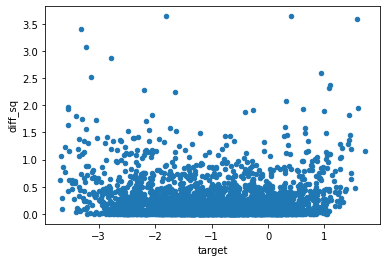

In [42]:
train_kf_df.plot(kind='scatter', x='target', y='diff_sq')

In [43]:
# 二乗誤差が2.0を超えるレコード
thr_ = 2.0 
train_kf_df[train_kf_df['diff_sq'] > thr_]

,id,url_legal,license,excerpt,target,standard_error,kfold,bins_tg,bins_std,bins,pred,diff_sq
44,47d6aff90,NaN,NaN,And it seemed to Tom Reynolds that all his Chr...,0.320072,0.501912,3,8,3,83,-1.122609,2.081331
141,bcd734621,NaN,NaN,Midas was enjoying himself in his treasure-roo...,0.943021,0.537713,0,10,5,105,-0.667733,2.594528
304,f04e03fd8,NaN,NaN,"Jupiter, two hours high, was the herald of the...",-3.229761,0.551435,1,0,6,6,-1.477481,3.070486
990,afeb324bd,NaN,NaN,"On the morning of the 20th of March, a long se...",0.401053,0.481889,0,9,2,92,-1.505391,3.634529
1152,03b761fd9,https://simple.wikipedia.org/wiki/Larva,CC BY-SA 3.0 and GFDL,Probably the most widely accepted theory expla...,-2.778515,0.533111,2,1,5,15,-1.086422,2.863180
1412,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776,1,11,10,1110,-0.307797,3.578315
1628,4cf4a2fa3,https://kids.frontiersin.org/article/10.3389/f...,CC BY 4.0,"Although anyone, from kids to the elderly, can...",-1.802185,0.518239,1,4,4,44,0.104900,3.636975
1689,8fb1cf05f,https://www.africanstorybook.org/,CC BY 4.0,Yuadoo is scared of the dark. Everyone feels f...,-2.199186,0.479532,0,3,2,32,-0.689919,2.277889
1879,4ac78e5c3,NaN,NaN,The next morning Ethel Hollister walked up to ...,-1.639354,0.526015,3,4,5,45,-0.140140,2.247640
1944,04ade0eb2,NaN,NaN,"While I was hailing the brig, I spied a tract ...",-3.315282,0.544735,2,0,6,6,-1.471602,3.399157


In [44]:
# 二乗誤差が2.0を超える文章
thr_ = 2.0 
tmp_df = train_kf_df[train_kf_df['diff_sq'] > thr_].copy()
for i in tmp_df.index:
  print(tmp_df.loc[i].target)
  #print(tmp_df.loc[i].standard_error)
  print(tmp_df.loc[i].pred)
  print(tmp_df.loc[i].excerpt)
  print('--------------------------')

0.32007246
-1.1226093769073486
And it seemed to Tom Reynolds that all his Christmas joy went skimming away behind him. The sun still shone, the ice still gleamed, the skaters laughed and sang, but Tom moved slowly on, with listless, heavy strokes. The "Jolly Ramblers" still twinkled beneath his feet, but he looked down at them no more. What was the use of "Jolly Ramblers" when Ralph Evans had a pair of "Club House" skates that cost a dollar more, had a graceful curve, and a faultless clamp, and were guaranteed for a year?
It was only four o'clock when Tom slipped his new skates carelessly over his shoulder and started up the bank for home. He was slouching down the main street, head down, hands thrust deep into his pockets, when, on turning a corner, he ran plump into—a full moon! Now I know it is rather unusual for full moons to be walking about the streets by daylight; but that is the only adequate description of the round, freckled face that beamed at Tom from behind a great box, he

In [55]:
%env MODEL_OUT_DIR '/content/drive/MyDrive/Colab_Files/kaggle/commonlit/98_model_inf/055-054-train-03'
!mkdir -p $MODEL_OUT_DIR
!cp -r /content/model/ $MODEL_OUT_DIR

env: MODEL_OUT_DIR='/content/drive/MyDrive/Colab_Files/kaggle/commonlit/98_model_inf/055-054-train-03'
^C


In [ ]:
!cp -r /content/model_1.pth /content/model/model_1.pth
!cp -r /content/model_2.pth /content/model/model_2.pth
!cp -r /content/model_3.pth /content/model/model_3.pth
!cp -r /content/model_4.pth /content/model/model_4.pth
!cp -r /content/model_5.pth /content/model/model_5.pth
!cp -r /content/TFIDF_1.pkl /content/model/TFIDF_1.pkl
!cp -r /content/TFIDF_2.pkl /content/model/TFIDF_2.pkl
!cp -r /content/TFIDF_3.pkl /content/model/TFIDF_3.pkl
!cp -r /content/TFIDF_4.pkl /content/model/TFIDF_4.pkl
!cp -r /content/TFIDF_5.pkl /content/model/TFIDF_5.pkl

In [59]:
model_path_out = Path('/content/model/')

In [65]:
for i in list(model_path_out.iterdir()):
  print(i)

/content/model/model_4.pth
/content/model/TFIDF_5.pkl
/content/model/TFIDF_1.pkl
/content/model/TFIDF_2.pkl
/content/model/TFIDF_3.pkl
/content/model/model_1.pth
/content/model/model_5.pth
/content/model/dataset-metadata.json
/content/model/TFIDF_4.pkl
/content/model/model_3.pth
/content/model/model_2.pth


In [70]:
import shutil
tgdir = Path('/content/drive/MyDrive/Colab_Files/kaggle/commonlit/98_model_inf/055-054')

for file_ in list(model_path_out.iterdir()):
  shutil.copy(file_, tgdir)